In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/Data And Information Quality/Project/'

/content/drive/MyDrive/Colab Notebooks/Data And Information Quality/Project


### Import libraries

In [ ]:
import dirty_completeness as dc
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

### Dataset Inspection

In [ ]:
ecoli_df = pd.read_csv('ecoli.csv')
ecoli_df.head()

,1,2,3,4,5,6,7,8,class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [ ]:
ecoli_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       336 non-null    object 
 1   2       336 non-null    float64
 2   3       336 non-null    float64
 3   4       336 non-null    float64
 4   5       336 non-null    float64
 5   6       336 non-null    float64
 6   7       336 non-null    float64
 7   8       336 non-null    float64
 8   class   336 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.8+ KB


In [ ]:
counts = ecoli_df['class'].value_counts()
counts

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: class, dtype: int64

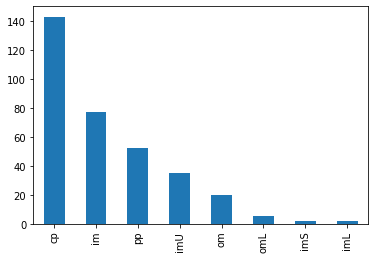

In [ ]:
counts.plot(kind='bar')
#plt.savefig('counts.png')

In [ ]:
ecoli_df = ecoli_df[~ecoli_df['class'].isin(counts[counts <= 5].index)]
ecoli_df = ecoli_df.reset_index(drop=True)
ecoli_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       327 non-null    object 
 1   2       327 non-null    float64
 2   3       327 non-null    float64
 3   4       327 non-null    float64
 4   5       327 non-null    float64
 5   6       327 non-null    float64
 6   7       327 non-null    float64
 7   8       327 non-null    float64
 8   class   327 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.1+ KB


In [ ]:
ecoli_df['1'].nunique()

327

In [ ]:
# since the first column contains identifiers it can be dropped
ecoli_df = ecoli_df.drop(['1'], axis=1)

### Data Imputation


*   Standard Imputation = **Median**
*   Advanced Imputation = **MICE**



In [ ]:
# create dirty datasets
dirty_datasets_med = dc.injection(ecoli_df, seed, 'ecoli', 'class')
dirty_datasets_mice = dirty_datasets_med.copy()

saved ecoli-completeness50%
saved ecoli-completeness60%
saved ecoli-completeness70%
saved ecoli-completeness80%
saved ecoli-completeness90%


In [ ]:
# extract the target classes from the dataset
y = ecoli_df['class']
classes = ecoli_df['class'].unique()
ecoli_df = ecoli_df.drop(['class'], axis=1)
classes

array(['cp', 'im', 'imU', 'om', 'pp'], dtype=object)

In [ ]:
# check which are the columns with missing data
dirty_target_med = []
dirty_target_mice = []

for i in range(len(dirty_datasets_med)):

  dirty_target_med.append(dirty_datasets_med[i]['class'])
  dirty_datasets_med[i] = dirty_datasets_med[i].drop(['class'], axis=1)

  dirty_target_mice.append(dirty_datasets_mice[i]['class'])
  dirty_datasets_mice[i] = dirty_datasets_mice[i].drop(['class'], axis=1)

  print(dirty_datasets_med[i].isnull().sum(), dirty_datasets_mice[i].isnull().sum())

2    155
3    165
4    173
5    155
6    159
7    158
8    159
dtype: int64 2    155
3    165
4    173
5    155
6    159
7    158
8    159
dtype: int64
2    136
3    137
4    133
5    127
6    137
7    140
8    130
dtype: int64 2    136
3    137
4    133
5    127
6    137
7    140
8    130
dtype: int64
2    102
3     87
4     98
5    103
6    107
7     91
8    100
dtype: int64 2    102
3     87
4     98
5    103
6    107
7     91
8    100
dtype: int64
2    61
3    72
4    69
5    68
6    75
7    64
8    53
dtype: int64 2    61
3    72
4    69
5    68
6    75
7    64
8    53
dtype: int64
2    30
3    32
4    39
5    25
6    30
7    36
8    26
dtype: int64 2    30
3    32
4    39
5    25
6    30
7    36
8    26
dtype: int64


In [ ]:
masks_med = [data.isnull() for data in dirty_datasets_med]
masks_mice = [data.isnull() for data in dirty_datasets_mice]

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

In [ ]:
# median imputation
for i in range(len(dirty_datasets_med)):

  simple_imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
  imp = simple_imputer.fit_transform(dirty_datasets_med[i])
  dirty_datasets_med[i] = pd.DataFrame(imp, columns=ecoli_df.columns)
  #data.info()

In [ ]:
dirty_datasets_med[0].isnull().sum()

2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# mice imputation
multivariate_impute_pipe = ColumnTransformer([
    ("impute_num", IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=15), max_iter=100), ecoli_df.columns)
]
)

for i in range(len(dirty_datasets_mice)):

  imp = multivariate_impute_pipe.fit_transform(dirty_datasets_mice[i])
  dirty_datasets_mice[i] = pd.DataFrame(imp, columns=ecoli_df.columns)

/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# check that all missing values have been imputed
dirty_datasets_mice[0].isnull().sum()

2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

Evaluate Imputation

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# median evaluation

rmse_med = []

for i, data in enumerate(dirty_datasets_med):

  mask = masks_med[i]

  val = ecoli_df[mask].values
  true_values = val[~np.isnan(val)]
  
  val = data[mask].values
  imp_values = val[~np.isnan(val)]

  rmse = np.sqrt(mean_squared_error(true_values[:,None], imp_values[:,None]))
  rmse_med.append(rmse)

In [ ]:
# mice evaluation

rmse_mice = []

for i, data in enumerate(dirty_datasets_mice):

  mask = masks_mice[i]

  val = ecoli_df[mask].values
  true_values = val[~np.isnan(val)]
  
  val = data[mask].values
  imp_values = val[~np.isnan(val)]

  rmse = np.sqrt(mean_squared_error(true_values[:,None], imp_values[:,None]))
  rmse_mice.append(rmse)

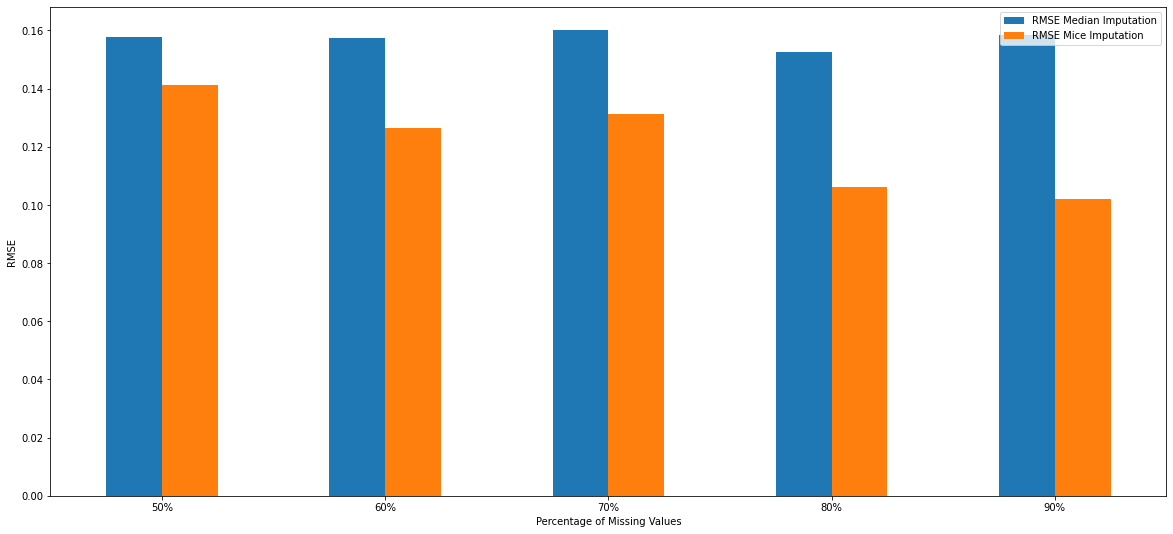

In [ ]:
dirty_proportions = ['50%', '60%', '70%', '80%', '90%']
df = pd.DataFrame({'RMSE Median Imputation': rmse_med, 'RMSE Mice Imputation': rmse_mice}, index=dirty_proportions)

fig, ax = plt.subplots(figsize=(20, 9))
df.plot.bar(ax=ax, rot=0)
ax.set(xlabel='Percentage of Missing Values', ylabel='RMSE')
plt.savefig('rmse.png')
plt.show()

### Classification



*   **Logistic Regression**
*   **SVM**



In [ ]:
from sklearn.model_selection import train_test_split

Train-Test Split

In [ ]:
X_train_med = []
X_test_med = []
y_train_med = []
y_test_med = []

for i in range(len(dirty_datasets_med)):

  X = dirty_datasets_med[i]
  y= dirty_target_med[i]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
  
  X_train_med.append(X_train)
  X_test_med.append(X_test)
  y_train_med.append(y_train)
  y_test_med.append(y_test)

In [ ]:
X_train_mice = []
X_test_mice = []
y_train_mice = []
y_test_mice = []

for i in range(len(dirty_datasets_mice)):

  X = dirty_datasets_mice[i]
  y= dirty_target_mice[i]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
  
  X_train_mice.append(X_train)
  X_test_mice.append(X_test)
  y_train_mice.append(y_train)
  y_test_mice.append(y_test)

Classification

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.svm import SVC

In [ ]:
# list of metrics for Logistic Regression
accuracies_lr_med = []
precisions_lr_med = []
recalls_lr_med = []
f1scores_lr_med = []
metrics_lr_med = []

In [ ]:
# list of metrics for SVM
accuracies_svm_med = []
precisions_svm_med = []
recalls_svm_med = []
f1scores_svm_med = []
metrics_svm_med = []

In [ ]:
for (X_train, X_test, y_train, y_test) in zip(X_train_med, X_test_med, y_train_med, y_test_med):

  logisticClassifier = LogisticRegression(multi_class='multinomial')
  logisticClassifier.fit(X_train, y_train)
  y_pred_lr = logisticClassifier.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred_lr)
  accuracies_lr_med.append(accuracy)

  precision = precision_score(y_test, y_pred_lr, average='macro')
  precisions_lr_med.append(precision)

  recall = recall_score(y_test, y_pred_lr, average='macro')
  recalls_lr_med.append(recall)

  f1 = f1_score(y_test, y_pred_lr, average='macro')
  f1scores_lr_med.append(f1)

  svmClassifier = SVC(kernel='rbf', decision_function_shape='ovo')
  svmClassifier.fit(X_train, y_train)
  y_pred_svm = svmClassifier.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred_svm)
  accuracies_svm_med.append(accuracy)

  precision = precision_score(y_test, y_pred_svm, average='macro')
  precisions_svm_med.append(precision)

  recall = recall_score(y_test, y_pred_svm, average='macro')
  recalls_svm_med.append(recall)

  f1 = f1_score(y_test, y_pred_svm, average='macro')
  f1scores_svm_med.append(f1)


  print(classification_report(y_test, y_pred_lr))
  print(classification_report(y_test, y_pred_svm))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: 

              precision    recall  f1-score   support

          cp       0.67      1.00      0.81        29
          im       0.53      0.50      0.52        16
         imU       0.00      0.00      0.00         7
          om       0.00      0.00      0.00         4
          pp       0.57      0.40      0.47        10

    accuracy                           0.62        66
   macro avg       0.36      0.38      0.36        66
weighted avg       0.51      0.62      0.55        66

              precision    recall  f1-score   support

          cp       0.78      1.00      0.88        29
          im       0.62      0.50      0.55        16
         imU       0.40      0.29      0.33         7
          om       0.50      0.25      0.33         4
          pp       0.67      0.60      0.63        10

    accuracy                           0.70        66
   macro avg       0.59      0.53      0.55        66
weighted avg       0.67      0.70      0.67        66

              precisio

In [ ]:
metrics_lr_med.extend([accuracies_lr_med, precisions_lr_med, recalls_lr_med, f1scores_lr_med])
metrics_svm_med.extend([accuracies_svm_med, precisions_svm_med, recalls_svm_med, f1scores_svm_med])

In [ ]:
# list of metrics for Logistic Regression
accuracies_lr_mice = []
precisions_lr_mice = []
recalls_lr_mice = []
f1scores_lr_mice = []
metrics_lr_mice = []

In [ ]:
# list of metrics for SVM
accuracies_svm_mice = []
precisions_svm_mice = []
recalls_svm_mice = []
f1scores_svm_mice = []
metrics_svm_mice = []

In [ ]:
for (X_train, X_test, y_train, y_test) in zip(X_train_mice, X_test_mice, y_train_mice, y_test_mice):

  logisticClassifier = LogisticRegression(multi_class='multinomial')
  logisticClassifier.fit(X_train, y_train)
  y_pred_lr = logisticClassifier.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred_lr)
  accuracies_lr_mice.append(accuracy)

  precision = precision_score(y_test, y_pred_lr, average='macro')
  precisions_lr_mice.append(precision)

  recall = recall_score(y_test, y_pred_lr, average='macro')
  recalls_lr_mice.append(recall)

  f1 = f1_score(y_test, y_pred_lr, average='macro')
  f1scores_lr_mice.append(f1)

  svmClassifier = SVC(kernel='rbf', decision_function_shape='ovo')
  svmClassifier.fit(X_train, y_train)
  y_pred_svm = svmClassifier.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred_svm)
  accuracies_svm_mice.append(accuracy)

  precision = precision_score(y_test, y_pred_svm, average='macro')
  precisions_svm_mice.append(precision)

  recall = recall_score(y_test, y_pred_svm, average='macro')
  recalls_svm_mice.append(recall)

  f1 = f1_score(y_test, y_pred_svm, average='macro')
  f1scores_svm_mice.append(f1)

  print(classification_report(y_test, y_pred_lr))
  print(classification_report(y_test, y_pred_svm))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetr

              precision    recall  f1-score   support

          cp       0.76      1.00      0.87        29
          im       0.50      0.62      0.56        16
         imU       0.00      0.00      0.00         7
          om       0.00      0.00      0.00         4
          pp       0.75      0.60      0.67        10

    accuracy                           0.68        66
   macro avg       0.40      0.45      0.42        66
weighted avg       0.57      0.68      0.62        66

              precision    recall  f1-score   support

          cp       0.78      1.00      0.88        29
          im       0.75      0.38      0.50        16
         imU       0.50      0.86      0.63         7
          om       0.00      0.00      0.00         4
          pp       0.67      0.60      0.63        10

    accuracy                           0.71        66
   macro avg       0.54      0.57      0.53        66
weighted avg       0.68      0.71      0.67        66

              precisio

In [ ]:
metrics_lr_mice.extend([accuracies_lr_mice, precisions_lr_mice, recalls_lr_mice, f1scores_lr_mice])
metrics_svm_mice.extend([accuracies_svm_mice, precisions_svm_mice, recalls_svm_mice, f1scores_svm_mice])

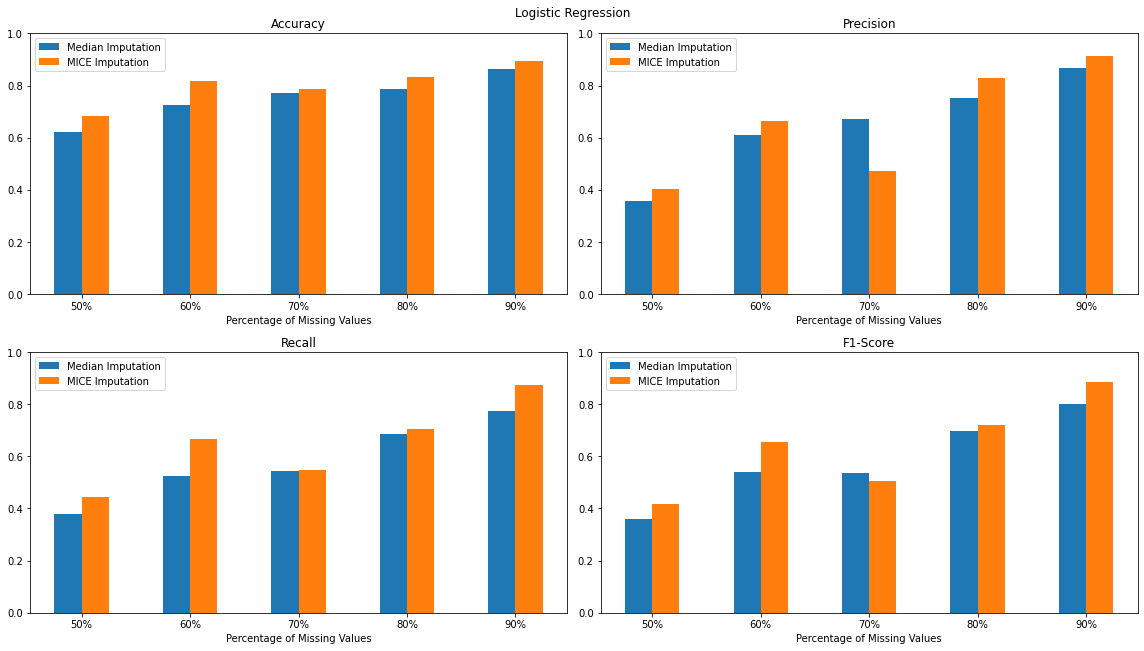

In [ ]:
metrics_lr = [metrics_lr_med, metrics_lr_mice]

dirty_proportions = ['50%', '60%', '70%', '80%', '90%']
metrics_name = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
imp_methods = ['Median Imputation', 'MICE Imputation']


barWidth = 0.25
pos1 = np.arange(len(dirty_proportions))
pos2 = [x + barWidth for x in pos1]
pos = [pos1, pos2]

fig, axs = plt.subplots(2, 2, figsize=(16,9))
axs = axs.flatten()

for i in range(len(metrics_name)):

  for j in range(len(imp_methods)):

    axs[i].bar(pos[j], metrics_lr[j][i], width=barWidth, label=imp_methods[j])
    axs[i].set_title(metrics_name[i])
    axs[i].set_ylim(0,1)
    axs[i].set(xlabel='Percentage of Missing Values')
    axs[i].set_xticks((pos1 + pos2)/2)
    axs[i].set_xticklabels(dirty_proportions)
    axs[i].legend()

fig.suptitle('Logistic Regression', y=1)
fig.tight_layout()
#plt.savefig('classification_lr.png')
plt.show()

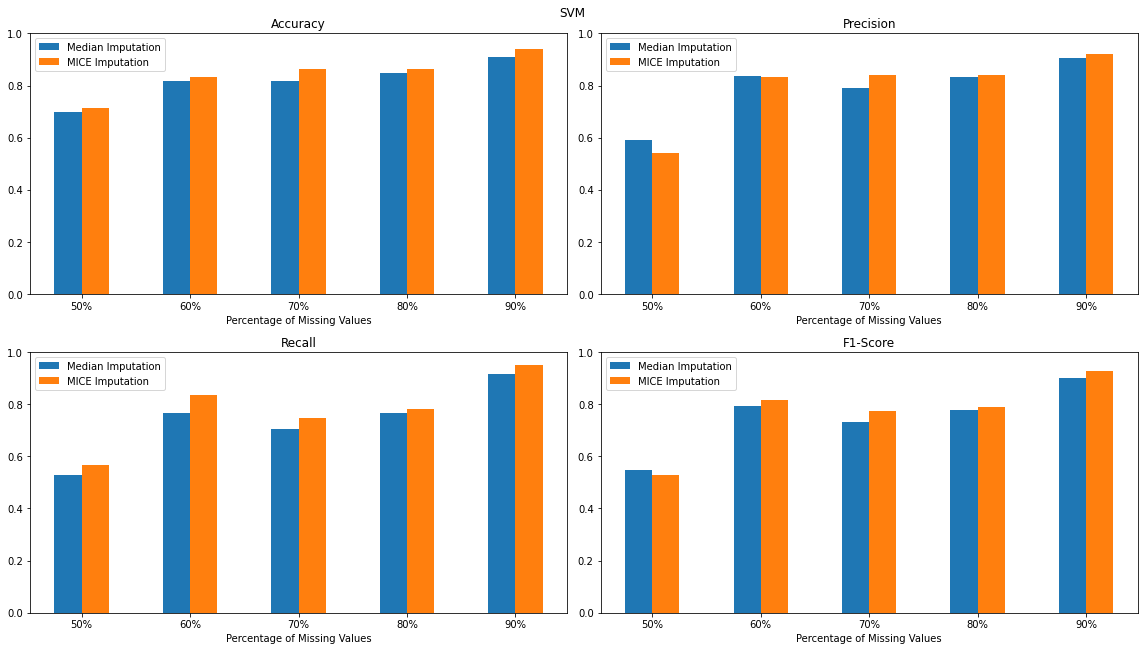

In [ ]:
metrics_svm = [metrics_svm_med, metrics_svm_mice]

dirty_proportions = ['50%', '60%', '70%', '80%', '90%']
metrics_name = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
imp_methods = ['Median Imputation', 'MICE Imputation']


barWidth = 0.25
pos1 = np.arange(len(dirty_proportions))
pos2 = [x + barWidth for x in pos1]
pos = [pos1, pos2]

fig, axs = plt.subplots(2, 2, figsize=(16,9))
axs = axs.flatten()

for i in range(len(metrics_name)):

  for j in range(len(imp_methods)):

    axs[i].bar(pos[j], metrics_svm[j][i], width=barWidth, label=imp_methods[j])
    axs[i].set_title(metrics_name[i])
    axs[i].set_ylim(0,1)
    axs[i].set(xlabel='Percentage of Missing Values')
    axs[i].set_xticks((pos1 + pos2)/2)
    axs[i].set_xticklabels(dirty_proportions)
    axs[i].legend()

fig.suptitle('SVM', y=1)
fig.tight_layout()
#plt.savefig('classification_svm.png')
plt.show()